#  Максимально правдоподобный вебинар

<div class="alert alert-info">

<b>Сегодня</b>
    
<b>Программа семинара № 15: </b>

Смысл метода максимального правдоподобия.
ММП и распределение Бернулли.
ММП и нормальное распределение.
Информация Фишера и свойства ММП-оценок.
Распределение ММП-оценок для нормальной случайной величины.
Тест отношения правдоподобий.
Дельта-метод.
ММП в python для разных распределений.
----------------------------------
    
<b>Программа семинара № 16: </b>    
    
    
Линейный регрессионный анализ. Модель, интерпретация оценок коэффициентов, множественный коэффициент детерминации. Интерпретация множественного. 
коэффициента детерминации, ограничения на область его применения. Выявление наиболее значимых предикторов и оценка вклада каждого предиктора. Алгоритмы. 
корректировки построенных моделей. Коллинеарность

In [45]:
import numpy as np
import pandas as pd

from scipy import stats 
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # more style :) 
%matplotlib inline

# 1. Фрекен Бок

<center>
<img src="http://semyarf.com/UPLOAD/2016/01/21/frekenbok-216_700_0.jpg" height="200" width="350"> 
</center>

[Как известно](https://www.livelib.ru/quote/305456-malysh-i-karlson-kotoryj-zhivet-na-kryshe-astrid-lindgren), Фрекен Бок пьёт коньяк по утрам. У нас даже есть дневные данные (в граммах):

In [2]:
x = [3.2, 7.9, 5.4, 4.9, 6.2, 4.3]

__а)__ Предполагая, что $x_i$ независимы и нормальны $N(\mu, \sigma^2)$ выпишем функцию правдоподобия.


$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$




$$
L(\mu, \sigma^2 \mid x_1, \ldots, x_n) =  \frac{1}{(2 \pi \sigma^2)^{\frac{n}{2}}} \cdot e^{- \sum_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2}}
$$

$$
\ln L(\mu, \sigma^2 \mid x_1, \ldots, x_n) \propto  -0.5 \cdot n \cdot \ln  \sigma^2 - \sum_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2} \to \max_{\mu, \sigma^2}
$$

$\propto$ - равенство с точностью до константы

Чтобы гарантировать положительность параметра $\sigma^2$ функция у нас будет зависеть от вектора параметров $\theta$, причем $\theta_1 = \mu$, а $\theta_2 = \ln \sigma^2$.

In [46]:
def lnL(theta, x):
    mu = theta[0]
    s2 = np.exp(theta[1])
    
    x = np.array(x)
    n = x.size
    
    l = -0.5*n*np.log(s2) - 0.5/s2*np.sum((x-mu)**2)
    return -l
    
lnL([4, 0.2], x)

10.240554617493236

__б)__ Оценим неизвестные параметры.

In [47]:
theta_init = [0, 0]
res = minimize(lnL, theta_init, args=x)
res

      fun: 5.353606615954044
 hess_inv: array([[0.35268761, 0.01306079],
       [0.01306079, 0.31987723]])
      jac: array([-1.90734863e-06,  2.02655792e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([5.31666596, 0.78453622])

In [48]:
mu, s2 = res.x
s2 = np.sqrt(np.exp(s2))
mu, s2

(5.316665963208802, 1.4803345526634897)

__в)__ Получим тот же результат используя встроенный метод `stats.norm.fit`:

In [49]:
mu, s = stats.norm.fit(x)
mu, s

(5.316666666666666, 1.4803340463857775)

__г)__ Построим $95\%$ доверительный интервал для $\mu$

In [7]:
res.hess_inv

array([[0.35268761, 0.01306079],
       [0.01306079, 0.31987723]])

In [8]:
np.var(x)/len(x)

0.3652314814814815

In [50]:
alpha = 0.05
z = stats.norm().ppf(1 - alpha/2)

left = res.x[0] - z*np.sqrt(res.hess_inv[0,0])
right = res.x[0] + z*np.sqrt(res.hess_inv[0,0])

print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [4.153; 6.481] ширины 2.328


__д)__ Проверим гипотезу о том, что $\mu = 1$ с помощью теста отношения правдоподобий. 

In [51]:
def lnL_r(theta, x):
    mu = 1
    s2 = np.exp(theta)
    
    x =np.array(x)
    n = x.size
    
    l = -0.5*n*np.log(s2) - 0.5/s2*np.sum((x-mu)**2)
    return -l
    
lnL_r(0.2, x)

51.75020379854693

In [52]:
theta_init = 0
res_r = minimize(lnL_r, theta_init, args=x)
res_r

      fun: 12.108462564158728
 hess_inv: array([[0.3327759]])
      jac: array([-2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([3.03615412])

In [12]:
lnL_r = res_r.fun
lnL_ur = res.fun

In [13]:
2*(lnL_r - lnL_ur)

13.509711896409367

In [53]:
stats.chi2(df=1).ppf(0.95)

3.841458820694124

Гипотеза отвергается! 

__е)__ Проверим гипотезу о том, что $\mu = 1$, а $\sigma^2 = 2$ с помощью теста отношения правдоподобий.

In [54]:
lnL_ur = res.fun
lnL_r = lnL([5,2.5], x)

In [55]:
2*(lnL_r - lnL_ur)

5.42145549917052

In [56]:
stats.chi2(df=2).ppf(0.95)

5.991464547107979

Гипотеза отвергается. 

# 2. Призраки

<center>
<img src="https://pbs.twimg.com/media/DqWmCg9X4AAkl0n.jpg" height="200" width="350"> 
</center>

А ещё Фрекен-Бок иногда видит привидения! Данные по количеству привидений у нас тоже есть :)

In [18]:
y =  [1, 2, 0, 0, 2, 0]

Предположим, что количество привидений имеет пуассоновское распределение с параметром $\lambda$. 

__а)__ Оцените $\lambda$ с помощью ММП:

Вероятность, что случайная величина $X$ примет значение $k$: 

$$
\mathbb{P}(X = k) = \frac{e^{-\lambda} \cdot \lambda^k}{k!}
$$

$$
L(\lambda \mid x_1, \ldots x_n) = \frac{e^{-\lambda} \cdot \lambda^{
x_1}}{x_1!} \cdot \ldots \cdot \frac{e^{-\lambda} \cdot \lambda^{x_n}}{x_n!}
$$

$$
\ln L(\lambda \mid x_1, \ldots x_n) = \cdot n + \ln \lambda \cdot \sum_{i=1}^n x_i - \sum_{i=1}^n x_i!  \propto - \lambda \cdot n + \ln \lambda \cdot \sum_{i=1}^n x_i \to \max_{\lambda}
$$

$\propto$ - равенство с точностью до константы


$$
\ln L(\lambda \mid x_1, \ldots x_n)  \propto  \sum_{i=1}^n [- \lambda + \ln \lambda \cdot x_i] \to \max_{\lambda}
$$

In [58]:
def lnL(theta, y):
    rate = np.exp(theta)
    y = np.array(y)
    l = -rate + np.log(rate)*y
    return -1*np.sum(l)

lnL(4, y)

307.5889001988654

In [59]:
theta_init = 0
res = minimize(lnL, theta_init, args=y)
res

      fun: 5.91160778397651
 hess_inv: array([[0.2006664]])
      jac: array([8.34465027e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-0.18231992])

Предположим, что в $i$-й день интенсивность пуассоновского распределения $\lambda_i$ связана с количеством выпитого коньяка формулой $\lambda_i = e^{a + b \cdot x_i}$. То есть, возможно, что Фрекен Бок видит призраков из-за коньяка. 

__б)__ Оценим параметры $a$ и $b$, выписав функцию правдоподобия. 

$$
\ln L(\lambda \mid x_1, \ldots x_n)  \propto  \sum_{i=1}^n [- \lambda_i + \ln \lambda_i \cdot x_i] \to \max_{a, b}
$$

$$
\lambda_i = \exp(a + b y_i)
$$

In [60]:
fbock = pd.DataFrame({
    'x': [3.2, 7.9, 5.4, 4.9, 6.2, 4.3], 
    'y': [1, 2, 0, 0, 2, 0]
})

In [22]:
def lnL(theta, fbock):
    x = np.array(fbock['x'])
    y = np.array(fbock['y'])
    
    a = theta[0]
    b = theta[1]

    rate = np.exp(a + b*x)
    l = -rate + np.log(rate)*y
    return -1*np.sum(l)

lnL([1, 2], fbock)

20635012.00334143

In [61]:
theta_init = [0, 0]
res = minimize(lnL, theta_init, args=fbock)
res

      fun: -15.488396859981759
 hess_inv: array([[3.13108315e-02, 1.03359942e-04],
       [1.03359942e-04, 1.99875491e-01]])
      jac: array([ 0.0000000e+00, -1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([ 1.67084654, -0.18232156])

__в)__ Построим прогнозы для парметра лямбда при разном объёме выпитого коньяка.

In [64]:
x_test = np.array([1, 2])
lam_hat = np.exp(res.x[0] + res.x[1]*x_test)
lam_hat

array([4.43055553, 3.69212958])

In [65]:
# ФБ увидит 1 призрака 
np.exp(-lam_hat)*lam_hat

array([0.05275849, 0.09200373])

По аналогии можем вычислить все интересующие нас вероятности. 

__в)__  Данная модель является довольно популярной и реализована в `statsmodels`. Она называется Пуассоновской регрессией. Оценим её. 

In [66]:
# !pip install statsmodels

In [67]:
import statsmodels.formula.api as smf

In [69]:
model = smf.poisson(data=fbock, formula="y ~ 1 + x")
model.fit().summary()

Optimization terminated successfully.
         Current function value: 1.047945
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                    6
Model:                        Poisson   Df Residuals:                        4
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Dec 2021   Pseudo R-squ.:                  0.1384
Time:                        10:16:11   Log-Likelihood:                -6.2877
converged:                       True   LL-Null:                       -7.2979
Covariance Type:            nonrobust   LLR p-value:                    0.1552
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5988      1.918     -1.355      0.175      -6.358       1.161
x              0.4170      0.297      1.404      0.160      -0.165       0.999
==============================================================================
"""

__г)__ C помощью полученного протокола, проверим гипотезу о взаимосвязи призраков и выпитого коньяка.

- Точечная оценка коэффицента перед коньяком равна $0.4170$. ММП даёт нам асимптотически нормальные оценки, то есть мы можем для проверки гипотез для коэффициента использовать $z-$тест. 
- В колонке $z$ посчитана статистика для гипотезы о равенстве коэффициента нулю (гипотеза о значимости коэффициента). Она оказалась равна $1.404$. Также для неё найдено p_value, оно оказалось равно $0.160$. То есть гипотеза о равенстве коэффициента нулю не отвергается. 

> Если все наши предпосылки выполнены и данные действительно имеют распределение Пуассона, коньяк никак не влияет на число увиденных приведений. 


# 3. Гифка с накоплением 

На гифке нарисовано как пуасоновская функция правдоподобия постепенно накапливается из отдельных наблюдений и становится более выраженной: 

![ ](./images/animation_likelihood.gif)



#  Регрессия - моя профессия

В этой тетрадке мы попробуем найте BLUE-оценки и проверить пару гипотез. 

In [79]:
import numpy as np
import pandas as pd

from scipy import stats 

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Данные

In [80]:
df = pd.read_csv('../data/Advertising.csv', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


__Описание колонок:__ 

- `Sales` - продажи продукта на данном рынке (в тысячах штук) 
- `TV` -  доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах

В нашей выборке мы имеем 200 **наблюдений** (200 разных рынков с разным объёмом рекламы)

## Вопросы

Давайте представим, что мы работаем на компанию, которая производит и продает этот товар. Компания может задать нам вопрос: как мы должны тратить наши рекламные деньги в будущем?

Этот общий вопрос может привести вас к более конкретным вопросам:

1. Существует ли связь между рекламой и продажами?
2. Насколько сильны эти отношения?
3. Какие типы рекламы способствуют росту продаж?
4. Зная расходы на рекламу на конкретном рынке, можем ли мы предсказать продажи?

# 1. Парная регрессия в уровнях

Взглянем как продажи зависят от типов рекламы.

C:\Users\sasha\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


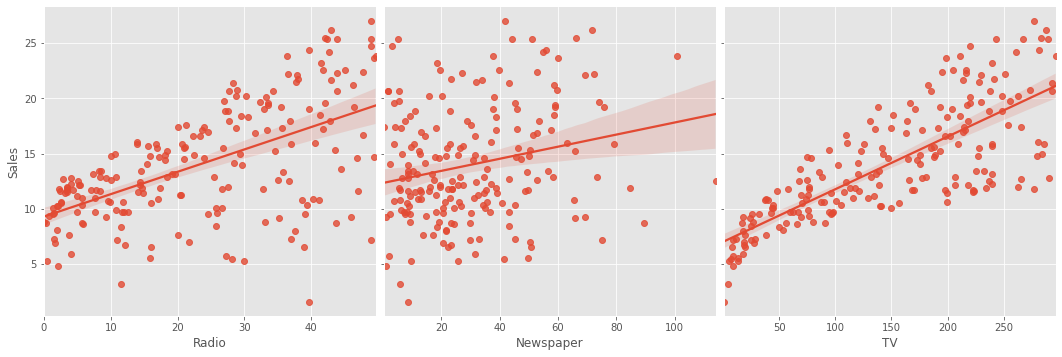

In [81]:
sns.pairplot(
    df, 
    y_vars='Sales', 
    x_vars=['Radio', 'Newspaper', 'TV'], 
    size=5,
    kind='reg',
    diag_kind=None
);

Для начала давайте поговорим только про рекламу на TV. Оценим параметры модели 

$$
Sales_i = \beta_0 + \beta_1 \cdot TV_i + \varepsilon_i
$$

In [82]:
import statsmodels.formula.api as smf

model = smf.ols('Sales ~ TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.47e-42
Time:                        10:37:24   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

In [83]:
res.params

Intercept    7.032594
TV           0.047537
dtype: float64

- Переменная $TV$ значима, так как $p$-значение для проверки гипотезы о том, что она равна нулю оказалось очень маленьким, наблюдаемое значение статистики $17.668$. Оно лежит глубоко в хвосте нашего распределения. 
- Получившееся уравнение 

$$
Sales_i = 7.033 + 0.047 \cdot TV_i
$$

можно проинтерпретировать так, что каждые дополнительные $1000$ долларов, потраченные на рекламу по телевизору, увеличивают продажы на $47.537$ товаров.

> Мы можем так интерпретировать значение коэффициента, если выполняются предпослыки линейной регрессии. Например, первая предпослыка говорит о том, что мы должны были верно специфицировать модель. 

Если модель специфицирована неверно, у нас есть проблемы. 

> Мы получаем корректные оценки стандартных ошибок в ситуации, когда ошибки независимо одинаково распределены с одинаковой дисперсией. Если это не так, оценки ошибок искажены. 

# 2. Парная регрессия в логарифмах

У нашей модели явно есть проблемы со спецификацией. Давайте попробуем их исправить. Если взглянуть на график того, как между собой взаимосвязаны реклама по TV и продажи, можно заметить нелинейную зависимость, похожую на логарифмическую. 

C:\Users\sasha\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


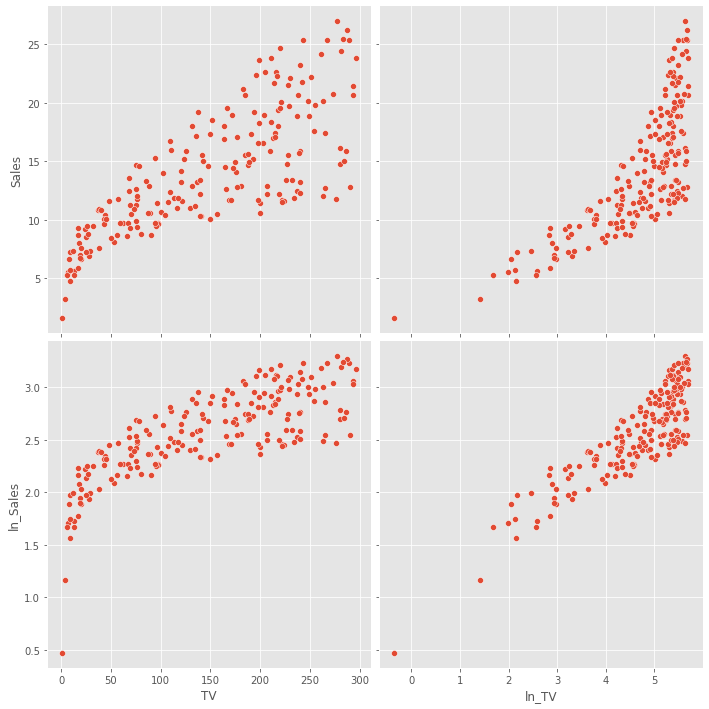

In [84]:
df['ln_TV'] = df['TV'].apply(np.log)
df['ln_Sales'] = df['Sales'].apply(np.log)

sns.pairplot(
    df, 
    y_vars=['Sales', 'ln_Sales'], 
    x_vars=['TV', 'ln_TV'], 
    size=5,
    diag_kind=None
);


Очистим данные от выбросов. 

In [85]:
df = df[df.Sales > df.Sales.quantile(0.01)]

Оценим параметры модели 

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \varepsilon_i
$$

In [86]:
import statsmodels.formula.api as smf

model = smf.ols('ln_Sales ~ ln_TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     435.1
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.16e-51
Time:                        10:37:25   Log-Likelihood:                 29.332
No. Observations:                 198   AIC:                            -54.66
Df Residuals:                     196   BIC:                            -48.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9757      0.078     12.443      0.0

Переменная снова значима. $R^2$ подрос. Все коэффициенты в моделях, где целевые и объясняющие переменные взяты в логарифмах, интерпретируются в процентных изменениях. Например, коэффициент $0.3550$ можно проинтерпретировать как то, на сколько процентов увеличутся продажи, при изменении трат на рекламу по телевизору на $1\%$. 

# 3. Множественная регрессия

Оценим уравнение 

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \beta_2 \cdot Radio_i + \beta_3 \cdot Newspaper_i + \varepsilon_i
$$

In [87]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2959.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):          1.17e-161
Time:                        10:39:18   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.022     30.446      0.0

- Уравнение значимо в целом, значение F-статистики попадает глубоко в хвост 
- Коэффициент перед `Newspaper` отрицательный и незначимый

> Если модель специфицирована верно и выполнены все предпосылки, мы можем сделать вывод, что траты на рекламу в газетах никак не повышают продажи и от них можно отказаться 

# 4. Проверка предпосылок модели

- Есть ли мультиколинеарность? 

In [41]:
df[['ln_TV', 'Radio', 'Newspaper']].corr()

,ln_TV,Radio,Newspaper
ln_TV,1.000000,0.004521,-0.004387
Radio,0.004521,1.000000,0.358916
Newspaper,-0.004387,0.358916,1.000000


Между переменными нет высокой корреляции. Значит у нас получится корректно оценить нашу модель. Есть другие, более формальне критерии для поиска проблем, связанных с мультиколинеарностью, но мы про них говорить не будем. 

- Корректны ли данные, с которыми мы работаем, для решения поставленной задачи? 
- Корректна ли спецификация модели? 
- Есть ли выборосы? 

Про всё это мы поговорили выше. Судя по всему, оценки коэффициентов, которые мы получили - несмещённые и состоятельные. 

- Есть ли в остатках __автокоррелированность__?

Для проверки этой предпосылки нам достаточно посмотреть в протокол оценивания и найти там строчку `Durbin-Watson`. Это статистика Дарбина-Уотсона. Если она оказывается в районе двух, то автокоррелированности в остатках нет. На самом деле это тоже статистика и для неё есть формальные критические значения, но мы в это углубляться не будем. Есть и другие критерии для проверки этой предпосылки. 

- Есть ли в остатках __гетероскедастичность__?

Для гетероскедастичности построим картинку и воспользуемся каким-нибудь критерием. 

C:\Users\sasha\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


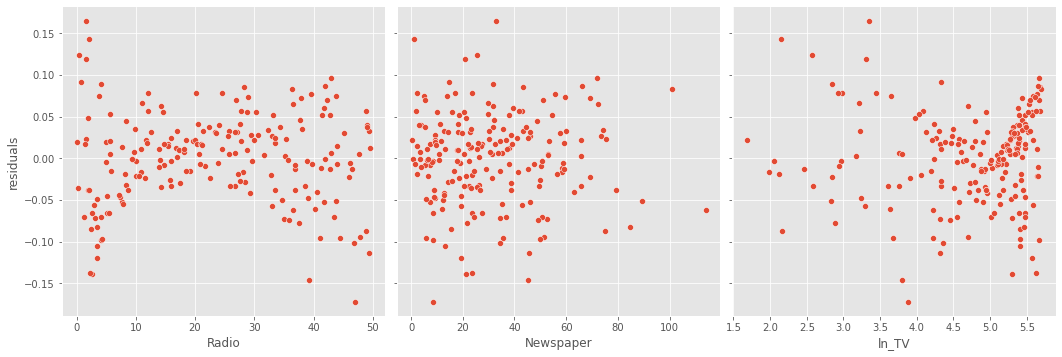

In [42]:
df['residuals'] = res.resid

sns.pairplot(
    df, 
    y_vars='residuals', 
    x_vars=['Radio', 'Newspaper', 'ln_TV'], 
    size=5,
    diag_kind=None
);

Судя по графику, дисперсия ошибок зависит от объёма рекламы по радио. Причём квадратично. Выходит, что оценки дисперсий коэффициентов искажены и доверительные интервалы оказываются смещёнными. Можно провести формальный тест на гомоскедастичность. Таких тестов есть довольно много. 

In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, df[['ln_TV', 'Radio', 'Newspaper']].values)

(51.35841835091481,
 7.041434689088952e-12,
 22.765010819359823,
 1.1142274879382572e-12)

Видим, что `pvalue` (последнее значение) сильно ниже уровня значимости. Гипотеза о гомоскедастичности отвергается. Можно ввести корректировку и исправить значения ошибок прямо при оценивании модели. 

In [44]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):          1.85e-141
Time:                        08:49:41   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.029     23.108      0.0

Значения стандартных ошибок довольно сильно изменились. Теперь мы можем использовать их для проверки гипотез. 

> Нормальность остатков нам не нужна. Из-за корректировки ошибок мы можем пользоваться только асимптотическими результатами. В данных нет выбросов, поэтому предельные теоремы тут работают. 

# 4. Выводы: 

1. Тратить деньги на рекламу в газетах неэффективно. Гипотеза о том, что коэффициент перед этой переменной равен нулю, не отвергается. 
2. Реклама по телевидению обладает убывающей отдачей от масштаба. Коэффициент перед логарифмом получился меньше единицы. Этот канал оказывается в плане рекламы самым эффективным. 
3. Канал, связанный с радио, судя по всему, недоиспользуется. Здравый смысл и микроэкономика подсказывают, что от него тоже логично ожидать убывающую от масштаба отдачу. Однако в данных мы видим, что она линейная. 